# Modules

In [6]:
import sys
sys.path.insert(1, "../module")
import numpy as np      
import snflics
from skimage.transform import resize
from netCDF4 import Dataset                             
from scipy.ndimage import zoom
from matplotlib.patches import Rectangle                
import cartopy.crs as ccrs                              
import cartopy.feature as cfeature                   
import matplotlib.pyplot as plt                         
plt.style.use('default')                               
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

# Geodata

## Grid Information Summary

original information

- `lats.shape == lons.shape == cores.shape == (2268, 2080)`
- `lats` and `lons` provide the geolocation (latitude and longitude) for each pixel in `cores`
- The grid is **not regular in geographic space** — the spacing between neighbouring lat/lon values **varies** across the array
- This is known as a **curvilinear grid**

In [7]:
# lat and lon meshgrids
geodata = np.load("/home/users/mendrika/EPS-Impact-Case-AI-Nowcasting/data/geodata/lat_lon_2268_2080.npz")
lons = geodata["lon"][:]
lats = geodata["lat"][:]

# Dakar lat lon
Dakar_lon = -17.467686
Dakar_lat = 14.716677

# Core data 

In [8]:
lats.shape

(2080, 2268)

In [9]:
year = '2023'
month = '07'
day = '03'
hour = '15'
minute = '15'

In [10]:
path_core = f'/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/{year}/{month}'

In [11]:
# file of interest at time t0
file = f'{path_core}/{year}{month}{day}{hour}{minute}.nc'

data = Dataset(file, mode='r')

# wavelet power maxima's coordinates
x0_lat = data["max_lat"][:]
x0_lon = data["max_lon"][:]

# cloud top temperature and wavelet power arrays
temp = data["tir"][0, :, :]
cores = data["cores"][0, :, :]
binary_cores = (cores != 0).astype(int)

# Plot Dakar Context Domain with Core Data

In [12]:
cores.shape

(2080, 2268)

top = 19.99001

bottom = -2.018712

left = -23.0

right = 32.021806

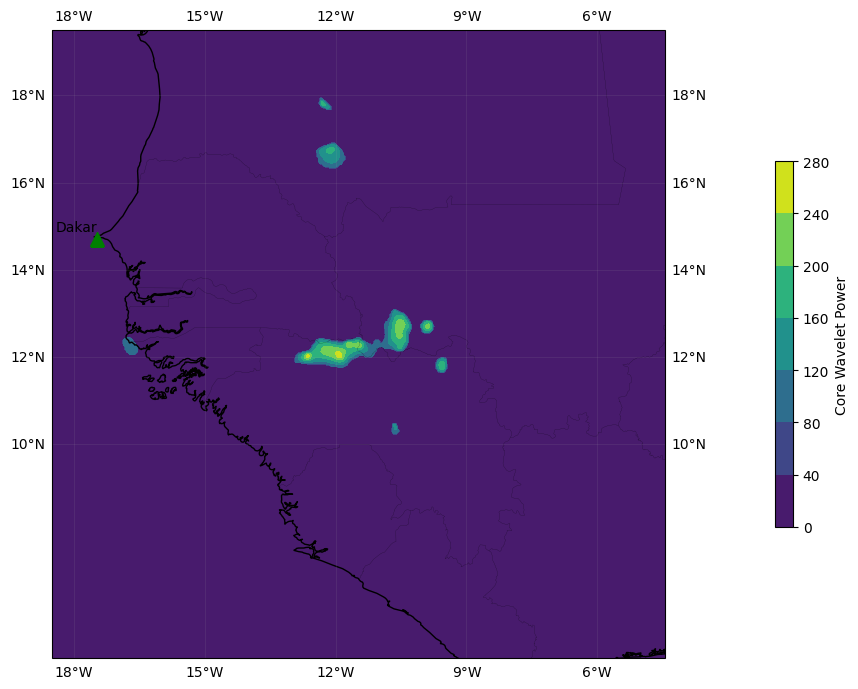

In [13]:
western_sahel_lat_min = 5.1
western_sahel_lat_max = 19.5
western_sahel_lon_min = -18.5  
western_sahel_lon_max = -4.45

extent = (
    western_sahel_lon_min,
    western_sahel_lon_max,
    western_sahel_lat_min,
    western_sahel_lat_max,
)

fig, ax = plt.subplots(
    figsize=(10, 7),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

ax.set_extent(extent, crs=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

gl = ax.gridlines(
    xlocs=np.arange(-18, 6, 3),
    ylocs=np.arange(10, 21, 2),
    draw_labels=True,
    alpha=0.1
)

admin_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)
ax.add_feature(admin_borders, edgecolor='black', linewidth=0.06)

contour_core = ax.contourf(
    lons, lats, cores,
    transform=ccrs.PlateCarree(),
    cmap="viridis"
)

cbar_core = plt.colorbar(contour_core, fraction=0.02, pad=0.12)
cbar_core.set_label("Core Wavelet Power")

plt.plot(Dakar_lon, Dakar_lat, marker="^", color="green", markersize=10)
plt.text(Dakar_lon, Dakar_lat + 0.1, "Dakar", ha="right", va="bottom")

plt.tight_layout()
plt.show()

In [14]:
WS_y_min, WS_x_min = snflics.to_yx(
    western_sahel_lat_min,
    western_sahel_lon_min,
    lats,
    lons
)

WS_y_max, WS_x_max = snflics.to_yx(
    western_sahel_lat_max,
    western_sahel_lon_max,
    lats,
    lons
)

print("Western Sahel index bounds:")
print(" y_min:", WS_y_min)
print(" y_max:", WS_y_max)
print(" x_min:", WS_x_min)
print(" x_max:", WS_x_max)

Western Sahel index bounds:
 y_min: 1403
 y_max: 1914
 x_min: 66
 x_max: 577


In [15]:
WS_y_min, WS_y_max, WS_x_min, WS_x_max = 1403, 1914, 66, 577

cores_WS = cores[WS_y_min:WS_y_max+1, WS_x_min:WS_x_max+1]

lats_WS = lats[WS_y_min:WS_y_max+1, WS_x_min:WS_x_max+1]
lons_WS = lons[WS_y_min:WS_y_max+1, WS_x_min:WS_x_max+1]

print("lats_WS shape:", lats_WS.shape)
print("lons_WS shape:", lons_WS.shape)

lats_WS shape: (512, 512)
lons_WS shape: (512, 512)


In [16]:
# Western Sahel bounds (reminder)
print("WS bounds:",
      western_sahel_lat_min,
      western_sahel_lat_max,
      western_sahel_lon_min,
      western_sahel_lon_max)

buffer = 3.0

context_lat_min = round(western_sahel_lat_min - buffer, 2)
context_lat_max = round(western_sahel_lat_max + buffer, 2)
context_lon_min = round(western_sahel_lon_min - buffer, 2)
context_lon_max = round(western_sahel_lon_max + buffer, 2)

print("Context bounds:",
      context_lat_min,
      context_lat_max,
      context_lon_min,
      context_lon_max)

WS bounds: 5.1 19.5 -18.5 -4.45
Context bounds: 2.1 22.5 -21.5 -1.45
